In [30]:
#Dependencies

import sys
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [2]:
#Retrieve data from Alpha Vantage

def get_stock_data(stock_name, api_key, output_size):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&apikey=%s&datatype=csv&outputsize=%s' % (stock_name, api_key, output_size)
    #load csv data from url
    stocks = pd.read_csv(url)
    #load data to DataFrame
    df = pd.DataFrame(stocks)
    
    return df

In [3]:
#Alpha Vantage

api_key = '5HSLKBUWSP7B6DOX'
stock_name = 'MSFT'

output_size = 'full'
df = get_stock_data(stock_name, api_key, output_size)

print(df.head(10))

print("The shape of dataframe is:")

print(df.shape)

    timestamp   open     high    low  close    volume
0  2017-07-19  73.50  74.0400  73.45  73.86  21769229
1  2017-07-18  73.09  73.3900  72.66  73.30  26435296
2  2017-07-17  72.80  73.4500  72.72  73.35  21481069
3  2017-07-14  72.24  73.2700  71.96  72.78  25689303
4  2017-07-13  71.50  72.0399  71.31  71.77  20149208
5  2017-07-12  70.69  71.2800  70.55  71.15  17747461
6  2017-07-11  70.00  70.6800  69.75  69.99  16880205
7  2017-07-10  69.46  70.2500  69.20  69.98  14903400
8  2017-07-07  68.70  69.8400  68.70  69.46  15897154
9  2017-07-06  68.27  68.7800  68.12  68.57  20909161
The shape of dataframe is:
(4414, 6)


In [4]:
#Feature selection and process

data = df.drop(df.columns[[0,3,5]], axis=1)

data.head(5)

,open,high,close
0,73.50,74.0400,73.86
1,73.09,73.3900,73.30
2,72.80,73.4500,73.35
3,72.24,73.2700,72.78
4,71.50,72.0399,71.77


In [5]:
#Data to csv

today = datetime.date.today()

dir_path = os.path.dirname(os.path.realpath('StockPredictor.ipynb'))
file_name = dir_path + "/data/" + stock_name +'_stock_%s.csv' % today
data.to_csv(file_name)

print(data)

         open      high   close
0      73.500   74.0400   73.86
1      73.090   73.3900   73.30
2      72.800   73.4500   73.35
3      72.240   73.2700   72.78
4      71.500   72.0399   71.77
5      70.690   71.2800   71.15
6      70.000   70.6800   69.99
7      69.460   70.2500   69.98
8      68.700   69.8400   69.46
9      68.270   68.7800   68.57
10     68.255   69.4400   69.08
11     69.330   69.6000   68.17
12     68.780   69.3800   68.93
13     69.380   69.4900   68.49
14     69.210   69.8410   69.80
15     70.110   70.1800   69.21
16     71.400   71.7100   70.53
17     70.090   71.2500   71.21
18     70.540   70.5900   70.26
19     70.210   70.6200   70.27
20     70.820   70.8700   69.91
21     70.500   70.9400   70.87
22     69.730   70.0300   70.00
23     69.270   70.2100   69.90
24     70.910   71.1000   70.27
25     70.020   70.8200   70.65
26     69.250   69.9400   69.78
27     72.035   72.0800   70.32
28     72.510   72.5200   71.95
29     72.635   72.7700   72.39
...     

In [6]:
#Feauture Scaling

data['high'] = data['high'] / 100
data['open'] = data['open'] / 100
data['close'] = data['close'] / 100
data.head(5)

,open,high,close
0,0.7350,0.740400,0.7386
1,0.7309,0.733900,0.7330
2,0.7280,0.734500,0.7335
3,0.7224,0.732700,0.7278
4,0.7150,0.720399,0.7177


In [7]:
#Function to seperate Training data and Testing data

def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [13]:
#lSTM

def lstm_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

#seq2seq model

def seq2seq(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation='relu'))        
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
        return model

In [20]:
#Separate Data

#Chosen the days when exchange is operating
seq_length = 22
X_train, y_train, X_test, y_test = load_data(data[::-1], seq_length)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (3952, 22, 3)
y_train: (3952,)
X_test: (439, 22, 3)
y_test: (439,)


In [21]:
# model = build_model([3,lag,1])
model = seq2seq([3, seq_length ,1])

In [23]:
#Fit model and train

model.fit(
    X_train,
    y_train,
    batch_size=256,
    nb_epoch=50,
    validation_split=0.1,
    verbose=1)

Train on 3556 samples, validate on 396 samples
Epoch 1/50
3556/3556 [==============================] - 12s - loss: 4.8347e-04 - acc: 2.8121e-04 - val_loss: 9.9471e-05 - val_acc: 0.0000e+00
Epoch 2/50
3556/3556 [==============================] - 13s - loss: 4.1055e-04 - acc: 2.8121e-04 - val_loss: 6.1663e-05 - val_acc: 0.0000e+00
Epoch 3/50
3556/3556 [==============================] - 12s - loss: 5.4319e-04 - acc: 2.8121e-04 - val_loss: 8.9690e-05 - val_acc: 0.0000e+00
Epoch 4/50
3556/3556 [==============================] - 11s - loss: 4.1256e-04 - acc: 2.8121e-04 - val_loss: 2.8737e-04 - val_acc: 0.0000e+00
Epoch 5/50
3556/3556 [==============================] - 12s - loss: 3.9782e-04 - acc: 2.8121e-04 - val_loss: 1.1688e-04 - val_acc: 0.0000e+00
Epoch 6/50
3556/3556 [==============================] - 13s - loss: 3.6542e-04 - acc: 2.8121e-04 - val_loss: 7.0006e-05 - val_acc: 0.0000e+00
Epoch 7/50
3556/3556 [==============================] - 12s - loss: 4.6946e-04 - acc: 2.8121e-04 - va

In [24]:
#Score

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


In [27]:
get_stock_data(stock_name, 0 , False)
window = 22
X_train, y_train, X_test, y_test = load_data(data[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3952, 22, 3)
y_train (3952,)
X_test (439, 22, 3)
y_test (439,)


In [32]:
print(X_test)
print(y_test)
#getPredictionData('TSLA',0)
window = 22
diff=[]
ratio=[]
p = model.predict(X_test)

for u in range(0, len(X_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
        

[[[ 0.435     0.4399    0.4348  ]
  [ 0.4362    0.4447    0.4411  ]
  [ 0.4338    0.4405    0.439   ]
  ..., 
  [ 0.4701    0.4703    0.4701  ]
  [ 0.4702    0.4754    0.4751  ]
  [ 0.4742    0.4788    0.4762  ]]

 [[ 0.4362    0.4447    0.4411  ]
  [ 0.4338    0.4405    0.439   ]
  [ 0.4393    0.4417    0.4387  ]
  ..., 
  [ 0.4702    0.4754    0.4751  ]
  [ 0.4742    0.4788    0.4762  ]
  [ 0.4744    0.4781    0.4777  ]]

 [[ 0.4338    0.4405    0.439   ]
  [ 0.4393    0.4417    0.4387  ]
  [ 0.4345    0.4413    0.4391  ]
  ..., 
  [ 0.4742    0.4788    0.4762  ]
  [ 0.4744    0.4781    0.4777  ]
  [ 0.4792    0.4799    0.472   ]]

 ..., 
 [[ 0.7002    0.7082    0.7065  ]
  [ 0.7091    0.711     0.7027  ]
  [ 0.6927    0.7021    0.699   ]
  ..., 
  [ 0.7       0.7068    0.6999  ]
  [ 0.7069    0.7128    0.7115  ]
  [ 0.715     0.720399  0.7177  ]]

 [[ 0.7091    0.711     0.7027  ]
  [ 0.6927    0.7021    0.699   ]
  [ 0.6973    0.7003    0.7     ]
  ..., 
  [ 0.7069    0.7128    0.7

Expected value:  73.3
Last Input:  [[ 69.27    70.21    69.9   ]
 [ 69.73    70.03    70.    ]
 [ 70.5     70.94    70.87  ]
 [ 70.82    70.87    69.91  ]
 [ 70.21    70.62    70.27  ]
 [ 70.54    70.59    70.26  ]
 [ 70.09    71.25    71.21  ]
 [ 71.4     71.71    70.53  ]
 [ 70.11    70.18    69.21  ]
 [ 69.21    69.841   69.8   ]
 [ 69.38    69.49    68.49  ]
 [ 68.78    69.38    68.93  ]
 [ 69.33    69.6     68.17  ]
 [ 68.255   69.44    69.08  ]
 [ 68.27    68.78    68.57  ]
 [ 68.7     69.84    69.46  ]
 [ 69.46    70.25    69.98  ]
 [ 70.      70.68    69.99  ]
 [ 70.69    71.28    71.15  ]
 [ 71.5     72.0399  71.77  ]
 [ 72.24    73.27    72.78  ]
 [ 72.8     73.45    73.35  ]]
Last Prediction:  [ 69.53839111]


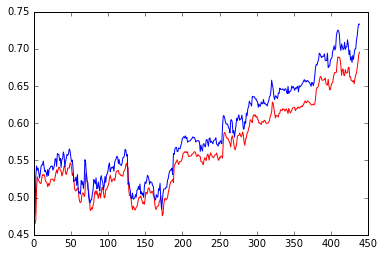

In [31]:
import matplotlib.pyplot as plt2
print("Expected value: ",(y_test[-1] * 100))
print("Last Input: ",(X_test[-1] * 100))
print("Last Prediction: ",(p[-1] * 100))
plt2.plot(p ,color='red', label='prediction')
plt2.plot(y_test ,color='blue', label='y_test')

#plt2.legend(loc='upper left')
plt2.show()